# Import the Libraries

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime
import inflection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from sklearn.impute import KNNImputer
import statsmodels.api as sm
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen 
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15.7,6.27)})

# Load the dataset

In [2]:
df_sales_raw=pd.read_csv('train.csv')
df_store_raw=pd.read_csv('store.csv')
#Load the dataset

In [3]:
# Let's merge the dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data preparation & understanding

In [4]:
#Copy dataset
df_new = df_raw.copy()
df_new.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
#Let raname the columns
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map( snakecase, old_columns ) )


#Rename Columns
df_new.columns = new_columns

In [6]:
df_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [7]:
#Let's check the shape of dataset
df_new.shape

(1017209, 18)

In [8]:
df_new[df_new['store']==8].head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
1122,8,4,2015-07-30,8420,882,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2237,8,3,2015-07-29,7029,698,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
3352,8,2,2015-07-28,6717,695,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4467,8,1,2015-07-27,8739,841,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN


In [9]:
#Store_8
df_new_store8=df_new[df_new['store']==8]

In [10]:
# transform datatype of the variable data to datetime
df_new_store8['date'] = pd.to_datetime( df_new_store8['date'])

In [11]:
df_new_store8.info()
#Let's check the info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 7 to 1016102
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [12]:
# Check NAN values
missing_count = df_new_store8.isnull().sum() # the count of missing values
value_count = df_new_store8.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.0
day_of_week,0,0.0
date,0,0.0
sales,0,0.0
customers,0,0.0
open,0,0.0
promo,0,0.0
state_holiday,0,0.0
school_holiday,0,0.0
store_type,0,0.0


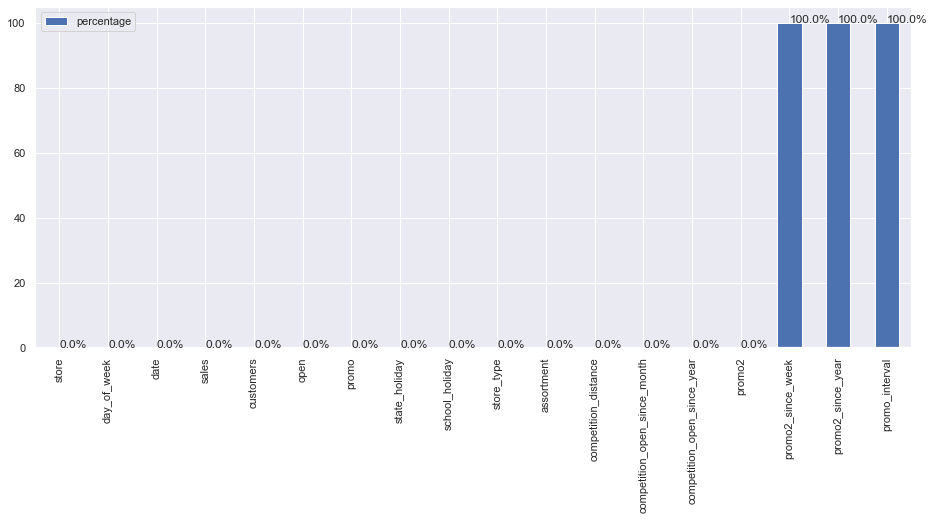

In [13]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [14]:
#Let's drop the promo2_since_year,promo2_since_year,promo_interval
df_new_store8=df_new_store8.drop(['promo2_since_week', 'promo2_since_year','promo_interval'], axis = 1)

In [15]:
df_new_store8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 7 to 1016102
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [16]:
df_new_store8 = df_new_store8.astype({'competition_open_since_month':'int64', 'competition_open_since_year':'int64',})
df_new_store8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 7 to 1016102
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [17]:
# Let's copy the dataset
df_store8 = df_new_store8.copy()

In [18]:
df_store8.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10,2014,0
1122,8,4,2015-07-30,8420,882,1,1,0,1,a,a,7520.0,10,2014,0
2237,8,3,2015-07-29,7029,698,1,1,0,1,a,a,7520.0,10,2014,0
3352,8,2,2015-07-28,6717,695,1,1,0,1,a,a,7520.0,10,2014,0
4467,8,1,2015-07-27,8739,841,1,1,0,1,a,a,7520.0,10,2014,0


**Descriptive Statistics**


In [19]:
df_store8.describe().T

,count,mean,std,min,25%,50%,75%,max
store,942.0,8.000000,0.000000,8.0,8.00,8.0,8.00,8.0
day_of_week,942.0,3.997877,1.998404,1.0,2.00,4.0,6.00,7.0
sales,942.0,4610.251592,2696.883772,0.0,2916.75,4919.0,6558.00,10971.0
customers,942.0,547.799363,293.404732,0.0,374.25,630.5,759.75,1133.0
open,942.0,0.832272,0.373823,0.0,1.00,1.0,1.00,1.0
promo,942.0,0.382166,0.486175,0.0,0.00,0.0,1.00,1.0
school_holiday,942.0,0.168790,0.374765,0.0,0.00,0.0,0.00,1.0
competition_distance,942.0,7520.000000,0.000000,7520.0,7520.00,7520.0,7520.00,7520.0
competition_open_since_month,942.0,10.000000,0.000000,10.0,10.00,10.0,10.00,10.0
competition_open_since_year,942.0,2014.000000,0.000000,2014.0,2014.00,2014.0,2014.00,2014.0


In [20]:
# separate numerical and categorical attributes
num_attributes = df_store8.select_dtypes( include = 'number')
cate_attributes = df_store8.select_dtypes( include = 'object')

**Numerical Attributes**


In [21]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,8.0,8.0,0.0,8.000000,8.0,0.000000,0.000000,0.000000
1,day_of_week,1.0,7.0,6.0,3.997877,4.0,1.997343,0.002127,-1.247185
2,sales,0.0,10971.0,10971.0,4610.251592,4919.0,2695.451925,-0.294658,-0.621236
3,customers,0.0,1133.0,1133.0,547.799363,630.5,293.248956,-0.770085,-0.496317
4,open,0.0,1.0,1.0,0.832272,1.0,0.373625,-1.781477,1.176152
5,promo,0.0,1.0,1.0,0.382166,0.0,0.485917,0.485772,-1.767783
6,school_holiday,0.0,1.0,1.0,0.168790,0.0,0.374566,1.771322,1.139998
7,competition_distance,7520.0,7520.0,0.0,7520.000000,7520.0,0.000000,0.000000,0.000000
8,competition_open_since_month,10.0,10.0,0.0,10.000000,10.0,0.000000,0.000000,0.000000
9,competition_open_since_year,2014.0,2014.0,0.0,2014.000000,2014.0,0.000000,0.000000,0.000000


**Categorical Attributes**

In [22]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday    5
store_type       1
assortment       1
dtype: int64

In [23]:
#Let's check the unique values
print(df_store8['state_holiday'].unique())
print(df_store8['store_type'].unique())
print(df_store8['assortment'].unique())

['0' 'a' 'b' 'c' 0]
['a']
['a']


# Exploratory data analysis(EDA)

Let’s perform EDA to gain insights into the given data.

**Univariate Analysis**

Response Variable (target)

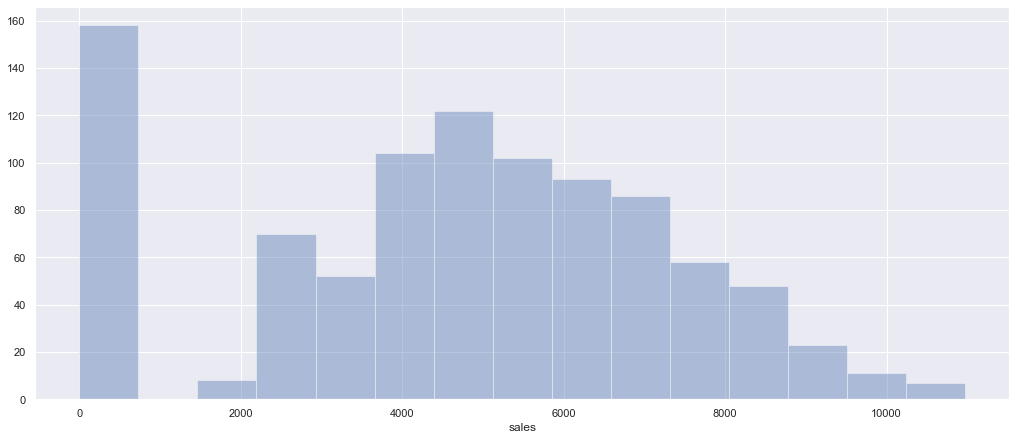

In [24]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df_store8['sales'], kde = False);
plt.show()

**Numerical Variable**


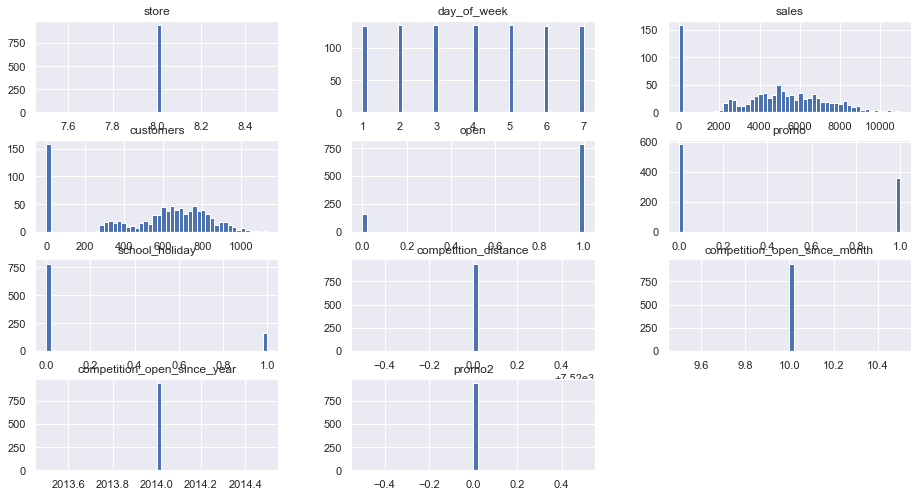

In [25]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
num_attributes.hist(bins = 50);

In [26]:
df_store8['day_of_week'].value_counts()
#day of the week

5    135
4    135
3    135
2    135
7    134
6    134
1    134
Name: day_of_week, dtype: int64

In [27]:
df_store8['open'].value_counts()
# value count of store is open or not

1    784
0    158
Name: open, dtype: int64

In [28]:
df_store8['promo'].value_counts()
# value count of promo

0    582
1    360
Name: promo, dtype: int64

In [29]:
df_store8['state_holiday'].value_counts()
# value count of state_holiday

0    789
0    129
a     14
b      6
c      4
Name: state_holiday, dtype: int64

In [30]:
df_store8['school_holiday'].value_counts()
# value count of state_holiday

0    783
1    159
Name: school_holiday, dtype: int64

In [31]:
df_store8['store_type'].value_counts()
# value count of state_holiday

a    942
Name: store_type, dtype: int64

In [32]:
df_store8['assortment'].value_counts()
# value count of state_holiday

a    942
Name: assortment, dtype: int64

In [33]:
df_store8['competition_distance'].value_counts()
# value count of state_holiday

7520.0    942
Name: competition_distance, dtype: int64

In [34]:
df_store8['competition_open_since_month'].value_counts()
# value count of state_holiday

10    942
Name: competition_open_since_month, dtype: int64

In [35]:
df_store8['competition_open_since_year'].value_counts()
# value count of state_holiday

2014    942
Name: competition_open_since_year, dtype: int64

In [36]:
df_store8['promo2'].value_counts()
# value count of state_holiday

0    942
Name: promo2, dtype: int64

**Categorical Variable**

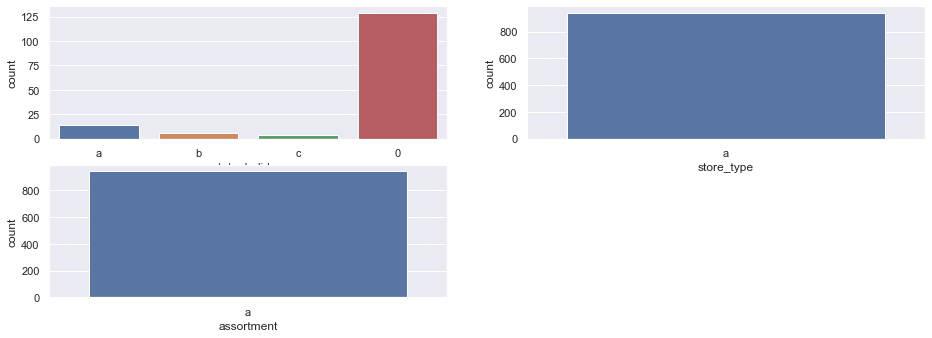

In [37]:
# state_holiday
plt.subplot(3, 2, 1)
a = df_store8[df_store8['state_holiday'] != '0']
sns.countplot(data = a, x = a['state_holiday'])

# store_type
plt.subplot(3, 2, 2)
sns.countplot(data = df_store8, x = df_store8['store_type'])

# assortment
plt.subplot(3, 2, 3)
sns.countplot(data = df_store8, x = df_store8['assortment'])

plt.show()

In [38]:
df_store8[df_store8['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
5582,8,7,2015-07-26,0,0,0,0,0,0,a,a,7520.0,10,2014,0
13387,8,7,2015-07-19,0,0,0,0,0,0,a,a,7520.0,10,2014,0
21192,8,7,2015-07-12,0,0,0,0,0,0,a,a,7520.0,10,2014,0
28997,8,7,2015-07-05,0,0,0,0,0,0,a,a,7520.0,10,2014,0
36802,8,7,2015-06-28,0,0,0,0,0,0,a,a,7520.0,10,2014,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987112,8,7,2013-01-27,0,0,0,0,0,0,a,a,7520.0,10,2014,0
994917,8,7,2013-01-20,0,0,0,0,0,0,a,a,7520.0,10,2014,0
1002722,8,7,2013-01-13,0,0,0,0,0,0,a,a,7520.0,10,2014,0
1010527,8,7,2013-01-06,0,0,0,0,0,0,a,a,7520.0,10,2014,0


In [39]:
df_store8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 7 to 1016102
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        


-    Sale  and customer colomns has zero values which has to be imputed

-    Store is open on 80% of days

-    80% are regular days

-    All the rows of column-store type belongs to 'a'

-    All the rows of column-assortment belongs to 'a'

-    All the rows of columns-competition_distance to 7520

-    All the competition is opened since month-10

-    All the competition is opened since 2014

-    All the rows of promo2 belogs to 0


**Bivariate Analysis**


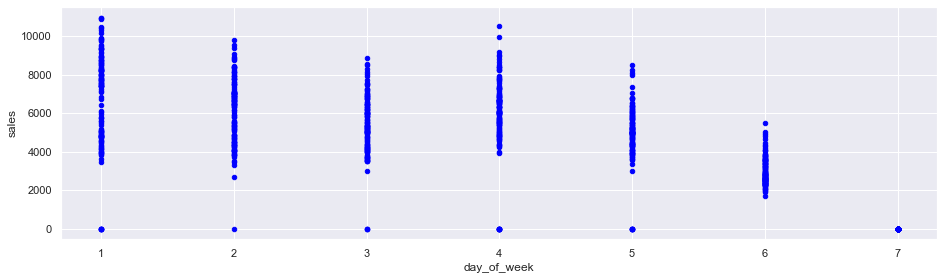

In [40]:
# lets draw a scatter plot between  Sales and day_of_week
sns.set(rc={'figure.figsize':(15.7,4.27)})
df_store8[['sales', 'day_of_week']].plot.scatter(x = 'day_of_week',y='sales',c='blue')
plt.show()

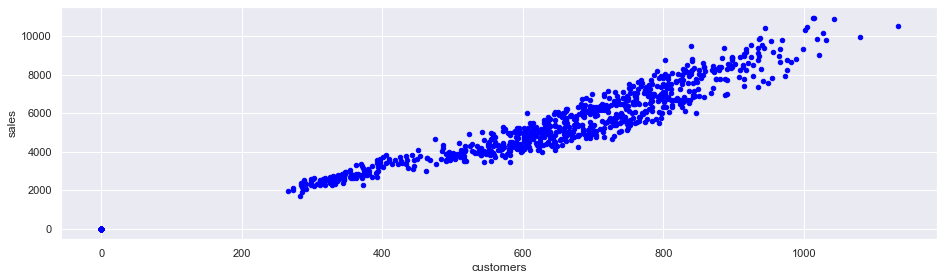

In [41]:
#Let's draw a scatter plot between Sales and Customers
df_store8[['sales', 'customers']].plot.scatter(x = 'customers',y='sales',c='blue')
plt.show()

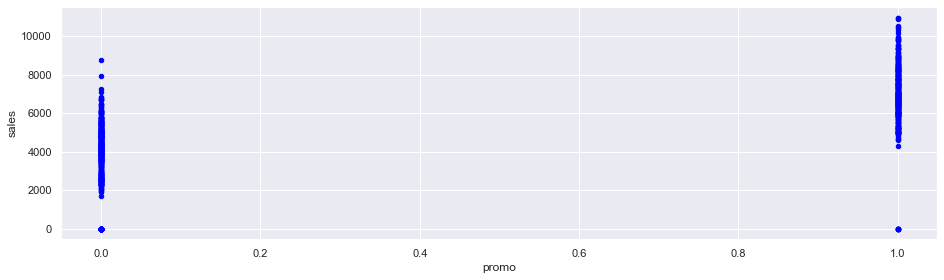

In [42]:
#Let's now draw a scatter plot between Sales and promo
df_store8[['sales', 'promo']].plot.scatter(x = 'promo',y='sales',c='blue')
plt.show()

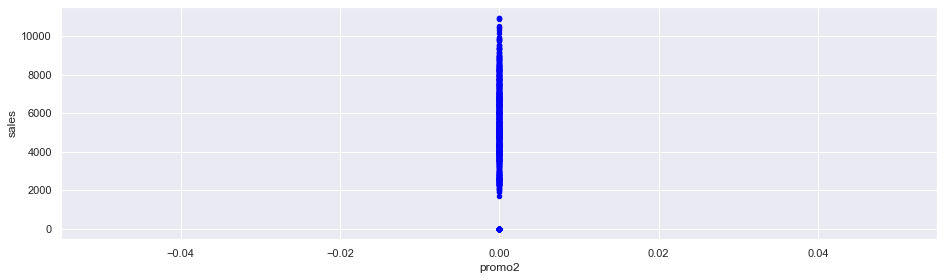

In [43]:
#Let's now draw a scatter plot between Sales and promo
df_store8[['sales', 'promo2']].plot.scatter(x = 'promo2',y='sales',c='blue')
plt.show()

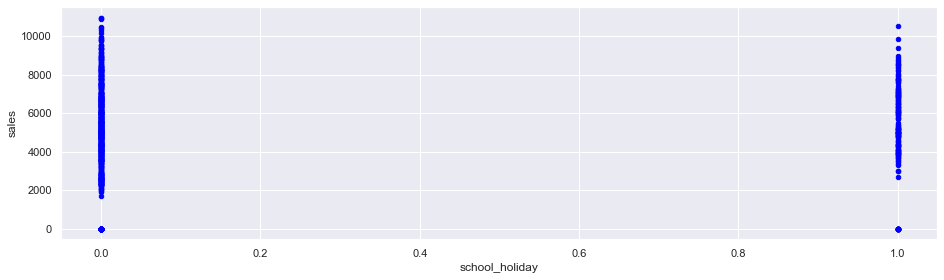

In [44]:
#lets now draw a scatter plot between  Sales and school_holiday
df_store8[['sales', 'school_holiday']].plot.scatter(x = 'school_holiday',y='sales',c='blue')
plt.show()

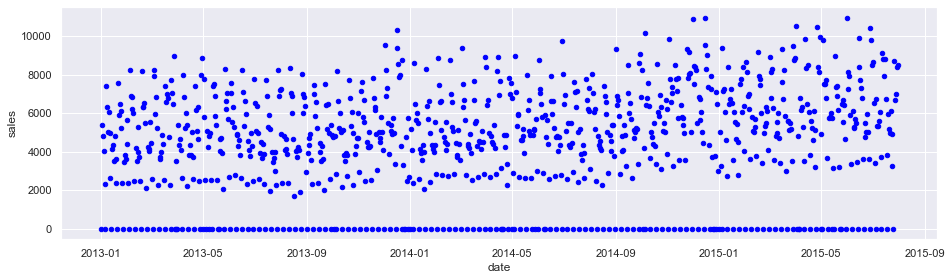

In [45]:
#lets now draw a scatter plot between Sales and date
df_store8[['sales', 'date']].plot.scatter(x = 'date',y='sales',c='blue')
plt.show()

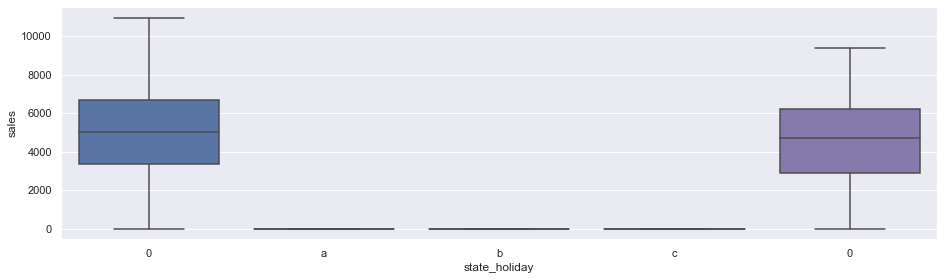

In [46]:
#Let's draw the boxplot between sales and state_holiday
sns.set(rc={'figure.figsize':(15.7,4.27)})
# create grouped boxplot 
sns.boxplot(x = df_store8['state_holiday'],
            y = df_store8['sales'])
plt.show()

**Multivariate Analysis**

**Numerical Attributes**

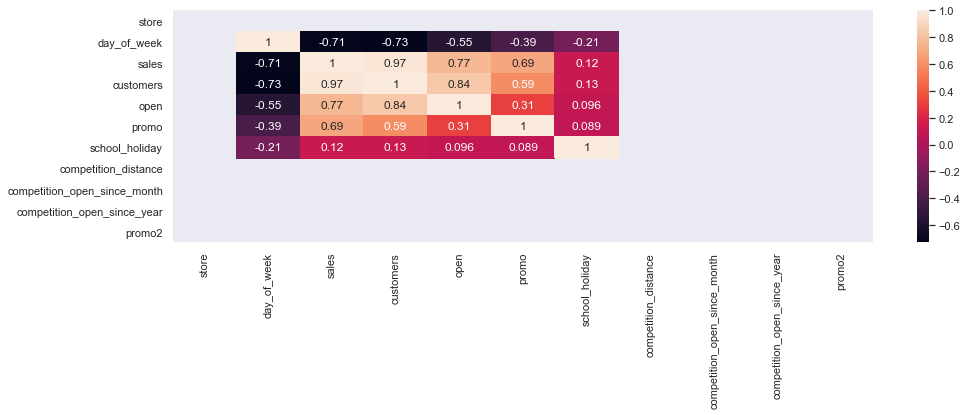

In [47]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

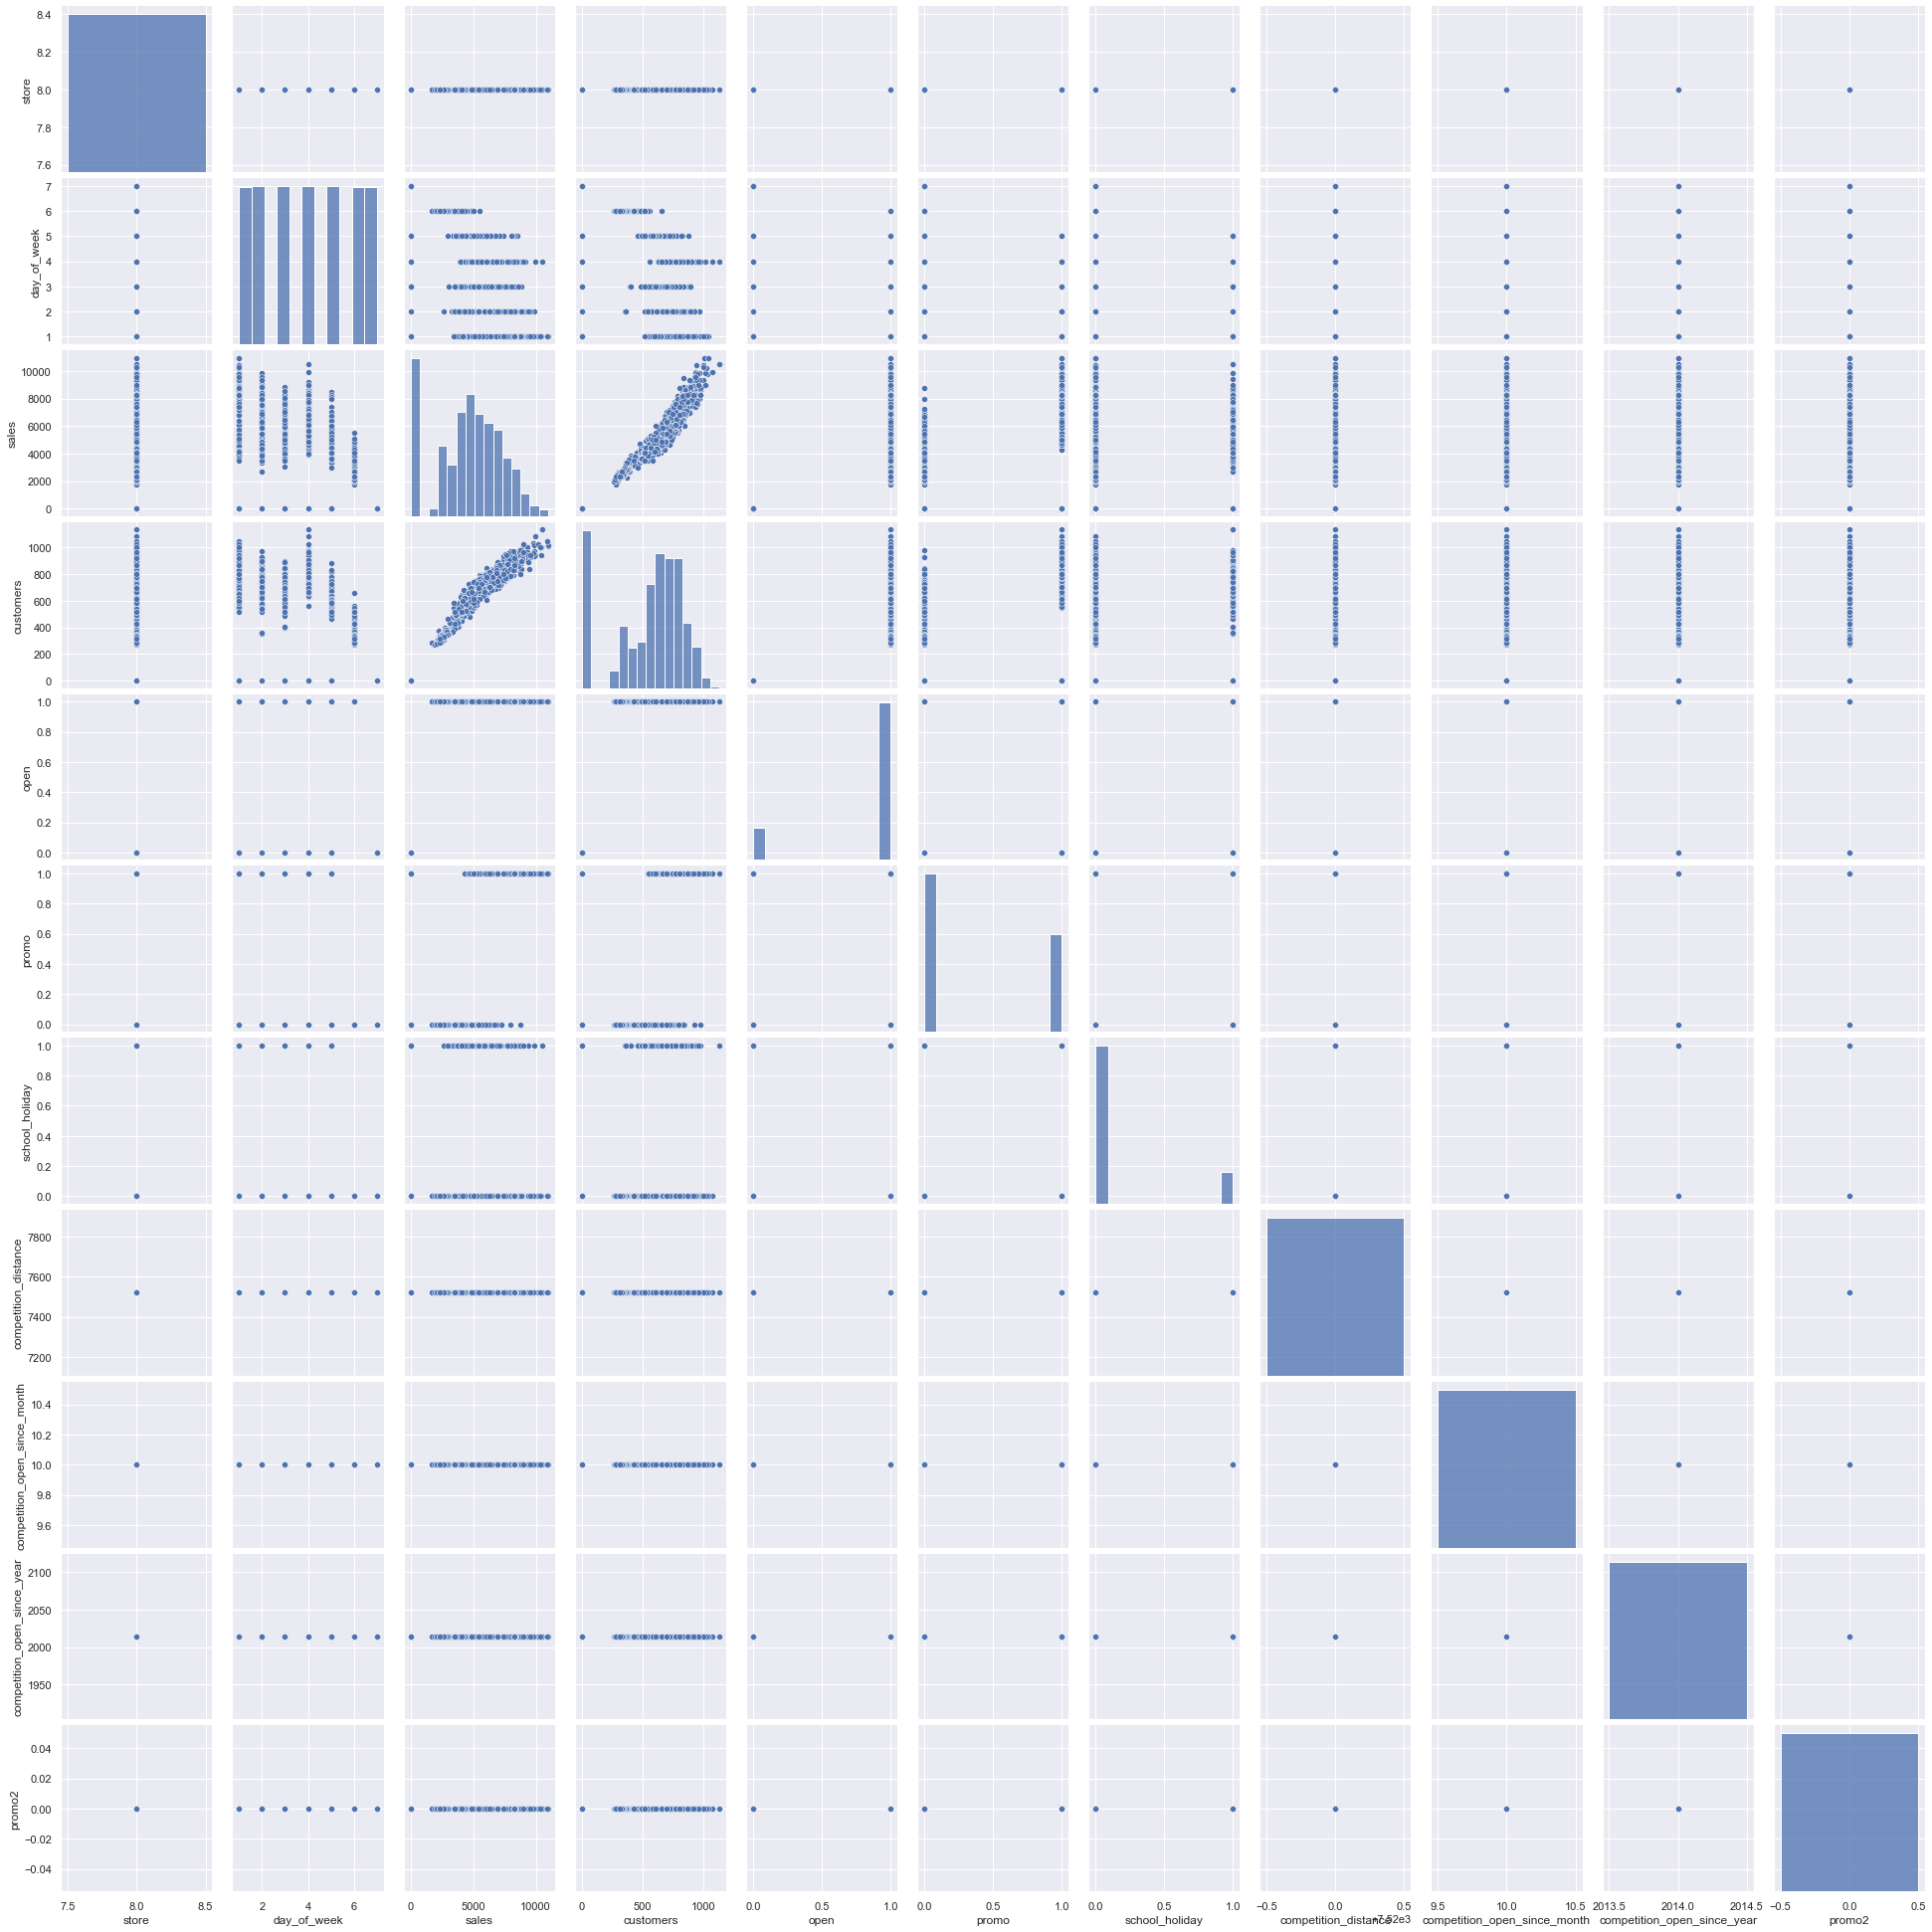

In [48]:
#pairplot with hue sales
sns.pairplot(df_store8)
# to show
plt.show()

**Some insights from EDA**

   - store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year

   - Day1,Day2 and Day4 have higher sales than other days

   - promo is correlated to sales

   - Promo2 doesn't have any effect on sales becuase it's value is equal to 0

   - There is no sale on a = public holiday, b = Easter holiday, c = Christmas

   - There is some effect of school holiday on sales


In [49]:
df_store8.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2'],
      dtype='object')

In [50]:
# We can drop store_type,assortment,competition_distance,competition_open_since_month,promo2_since_week,promo2_since_year,promo_interval
#competition_open_since_year & promo2
df_store8_new=df_store8.drop(['store_type', 'assortment','competition_distance','competition_open_since_month','competition_open_since_year'], axis = 1)

In [51]:
df_store8_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 7 to 1016102
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           942 non-null    int64         
 1   day_of_week     942 non-null    int64         
 2   date            942 non-null    datetime64[ns]
 3   sales           942 non-null    int64         
 4   customers       942 non-null    int64         
 5   open            942 non-null    int64         
 6   promo           942 non-null    int64         
 7   state_holiday   942 non-null    object        
 8   school_holiday  942 non-null    int64         
 9   promo2          942 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 121.0+ KB


In [52]:
df_store8_new.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
7,8,5,2015-07-31,8492,833,1,1,0,1,0
1122,8,4,2015-07-30,8420,882,1,1,0,1,0
2237,8,3,2015-07-29,7029,698,1,1,0,1,0
3352,8,2,2015-07-28,6717,695,1,1,0,1,0
4467,8,1,2015-07-27,8739,841,1,1,0,1,0


In [ ]:
# saving the dataframe
#df_store8_new.to_csv('cleaned_df_store8.csv')

# Model Building

**ARIMA model**

In [53]:
path = "cleaned_df_store8.csv"
df_store8_new = pd.read_csv(path)
df_store8_new.head()
#Let load the data

,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,7,8,5,2015-07-31,8492,833,1,1,0,1,0
1,1122,8,4,2015-07-30,8420,882,1,1,0,1,0
2,2237,8,3,2015-07-29,7029,698,1,1,0,1,0
3,3352,8,2,2015-07-28,6717,695,1,1,0,1,0
4,4467,8,1,2015-07-27,8739,841,1,1,0,1,0


In [54]:
df_store8_new=df_store8_new[::-1].reset_index()
df_store8_new.head()

,index,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,941,1016102,8,2,2013-01-01,0,0,0,0,a,1,0
1,940,1014987,8,3,2013-01-02,5419,698,1,0,0,1,0
2,939,1013872,8,4,2013-01-03,4842,662,1,0,0,1,0
3,938,1012757,8,5,2013-01-04,4059,517,1,0,0,1,0
4,937,1011642,8,6,2013-01-05,2337,312,1,0,0,0,0


In [55]:
df_store8_new=df_store8_new.drop(['Unnamed: 0'], axis = 1)
df_store8_new=df_store8_new.drop(['index'], axis = 1)
df_store8_new.head()
#Let drop the Unnamed: 0 column

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,8,2,2013-01-01,0,0,0,0,a,1,0
1,8,3,2013-01-02,5419,698,1,0,0,1,0
2,8,4,2013-01-03,4842,662,1,0,0,1,0
3,8,5,2013-01-04,4059,517,1,0,0,1,0
4,8,6,2013-01-05,2337,312,1,0,0,0,0


In [56]:
df_store8_new.info()
#No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   store           942 non-null    int64 
 1   day_of_week     942 non-null    int64 
 2   date            942 non-null    object
 3   sales           942 non-null    int64 
 4   customers       942 non-null    int64 
 5   open            942 non-null    int64 
 6   promo           942 non-null    int64 
 7   state_holiday   942 non-null    object
 8   school_holiday  942 non-null    int64 
 9   promo2          942 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 73.7+ KB


In [57]:
# transform datatype of the variable data to datetime
df_store8_new['date'] = pd.to_datetime(df_store8_new['date'])

In [60]:
indexed_df_store8_new = df_store8_new.set_index(['date'])
indexed_df_store8_new.head()
#Let set the date as index column

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,8,2,0,0,0,0,a,1,0
2013-01-02,8,3,5419,698,1,0,0,1,0
2013-01-03,8,4,4842,662,1,0,0,1,0
2013-01-04,8,5,4059,517,1,0,0,1,0
2013-01-05,8,6,2337,312,1,0,0,0,0


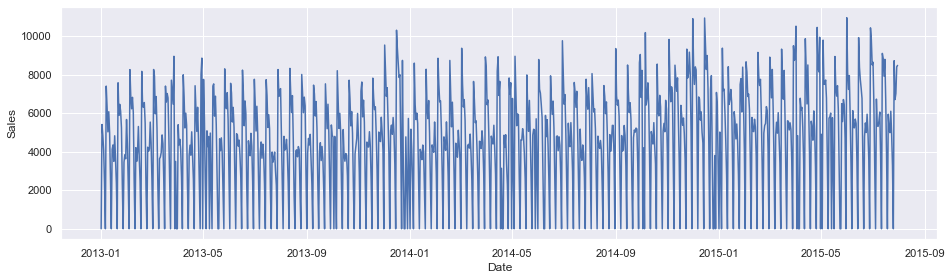

In [61]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store8_new['sales'])
plt.show()

In [62]:
#Let impute the zero values
(indexed_df_store8_new['sales']==0).sum()
# There are 158 zero value in sale column

158

In [63]:
indexed_df_store8_new['sales']=indexed_df_store8_new['sales'].replace(0, np.nan)

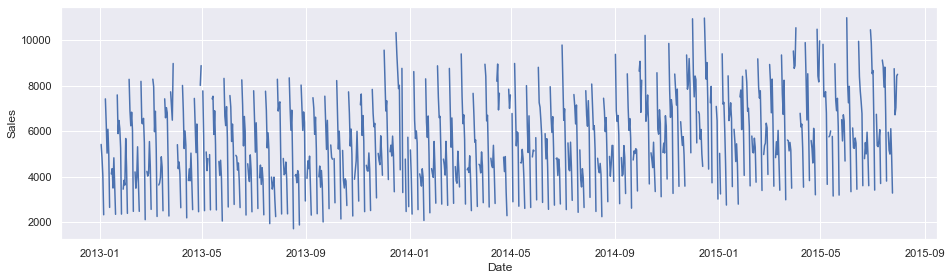

In [64]:
##plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store8_new['sales'])
plt.show()

In [65]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [66]:
indexed_df_store8_new['sales'] = imputer.fit_transform(np.array(indexed_df_store8_new['sales']).reshape(-1, 1))
indexed_df_store8_new['sales'].head()

date
2013-01-01    5539.358418
2013-01-02    5419.000000
2013-01-03    4842.000000
2013-01-04    4059.000000
2013-01-05    2337.000000
Name: sales, dtype: float64

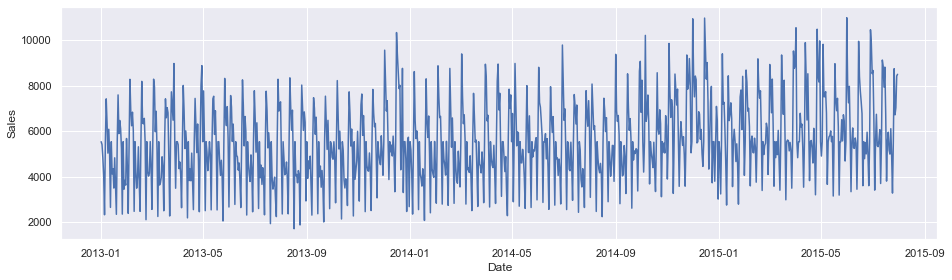

In [67]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store8_new['sales'])
plt.show()

In [68]:
(indexed_df_store8_new['sales']==0).sum()
# no missing value

0

**Outlier detection**

Box plot and interquartile range

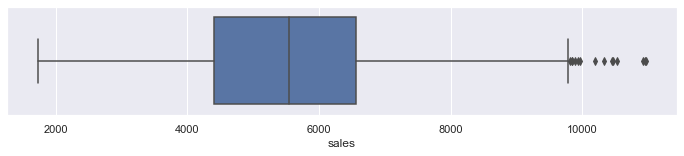

In [69]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store8_new['sales'],whis=1.5)
#Let treat the outliers

**Histogram**

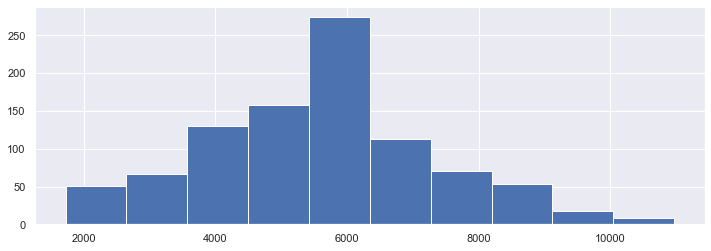

In [70]:
fig = indexed_df_store8_new['sales'].hist(figsize = (12,4))

In [71]:
percentile01 = indexed_df_store8_new['sales'].quantile(0.01)
percentile99 = indexed_df_store8_new['sales'].quantile(0.99)

In [72]:
upper_limit = percentile99
lower_limit = percentile01

In [73]:
upper_limit

9914.04

In [74]:
lower_limit

2255.23

In [75]:
new_df = indexed_df_store8_new[indexed_df_store8_new['sales'] < upper_limit]
new_df.shape

(932, 9)

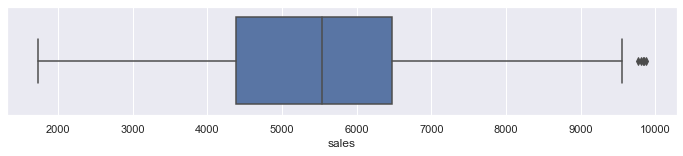

In [76]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['sales'],whis=1.5)

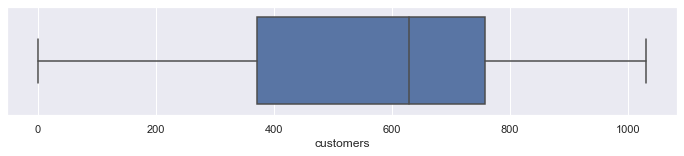

In [77]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['customers'],whis=1.5)

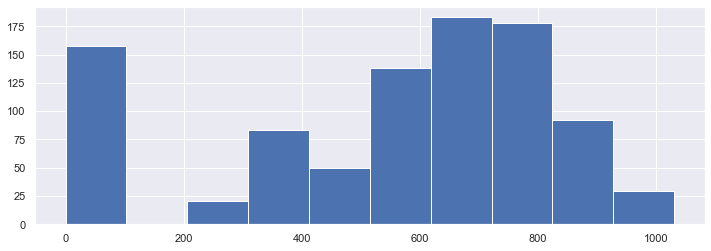

In [78]:
fig = new_df['customers'].hist(figsize = (12,4))

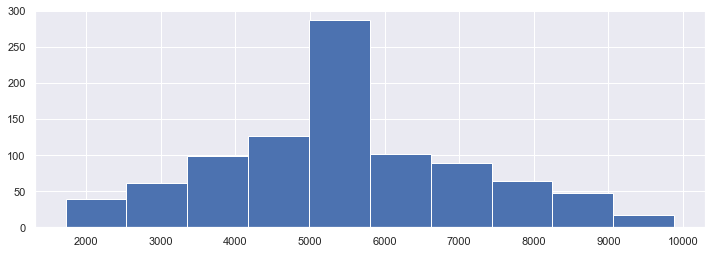

In [79]:
fig = new_df['sales'].hist(figsize = (12,4))

**ADF Stationary**

In [80]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(indexed_df_store8_new['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

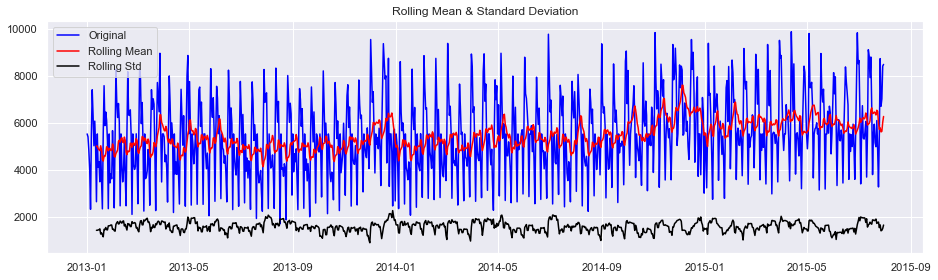

Results of Dickey Fuller Test:
Test Statistic                  -3.516398
p-value                          0.007576
#Lags Used                      22.000000
Number of Observations Used    919.000000
Critical Value (1%)             -3.437486
Critical Value (5%)             -2.864690
Critical Value (10%)            -2.568447
dtype: float64


In [81]:
test_stationarity(new_df['sales'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [83]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 2.561074
Critical Values @ 0.05: 0.46
p-value: 0.010000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary
    
**The p-value is less than 0.05 so The series is non-stationary**

# Let's take the log of sales to Standardize the sales values

In [84]:
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,8,2,5539.358418,0,0,0,a,1,0
2013-01-02,8,3,5419.000000,698,1,0,0,1,0
2013-01-03,8,4,4842.000000,662,1,0,0,1,0
2013-01-04,8,5,4059.000000,517,1,0,0,1,0
2013-01-05,8,6,2337.000000,312,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2015-07-27,8,1,8739.000000,841,1,1,0,1,0
2015-07-28,8,2,6717.000000,695,1,1,0,1,0
2015-07-29,8,3,7029.000000,698,1,1,0,1,0


In [85]:
#Log Transformation
new_df['sales_log'] = np.log(new_df['sales'])
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log
date,,,,,,,,,,
2013-01-01,8,2,5539.358418,0,0,0,a,1,0,8.619634
2013-01-02,8,3,5419.000000,698,1,0,0,1,0,8.597667
2013-01-03,8,4,4842.000000,662,1,0,0,1,0,8.485083
2013-01-04,8,5,4059.000000,517,1,0,0,1,0,8.308692
2013-01-05,8,6,2337.000000,312,1,0,0,0,0,7.756623
...,...,...,...,...,...,...,...,...,...,...
2015-07-27,8,1,8739.000000,841,1,1,0,1,0,9.075551
2015-07-28,8,2,6717.000000,695,1,1,0,1,0,8.812397
2015-07-29,8,3,7029.000000,698,1,1,0,1,0,8.857800


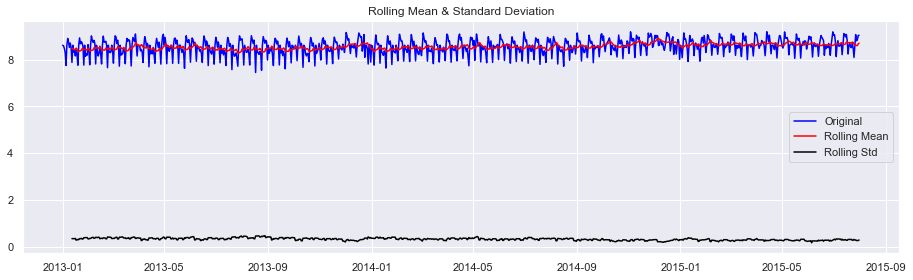

Results of Dickey Fuller Test:
Test Statistic                  -3.516398
p-value                          0.007576
#Lags Used                      22.000000
Number of Observations Used    919.000000
Critical Value (1%)             -3.437486
Critical Value (5%)             -2.864690
Critical Value (10%)            -2.568447
dtype: float64


In [86]:
test_stationarity(new_df['sales_log'])

**Log transformation has made mean & variance constant**

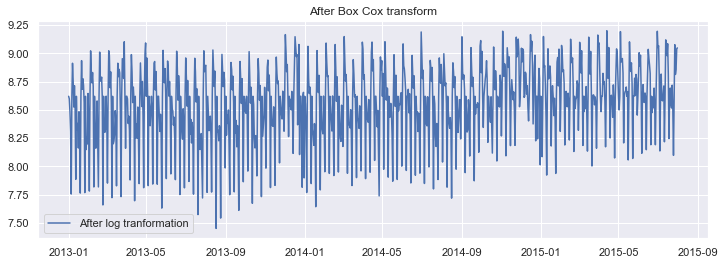

In [89]:
#After Log Transformation
plt.figure(figsize=(12,4))
plt.plot(new_df['sales_log'], label='After log tranformation')
plt.legend(loc='best')
plt.title('After log transform')
plt.show()

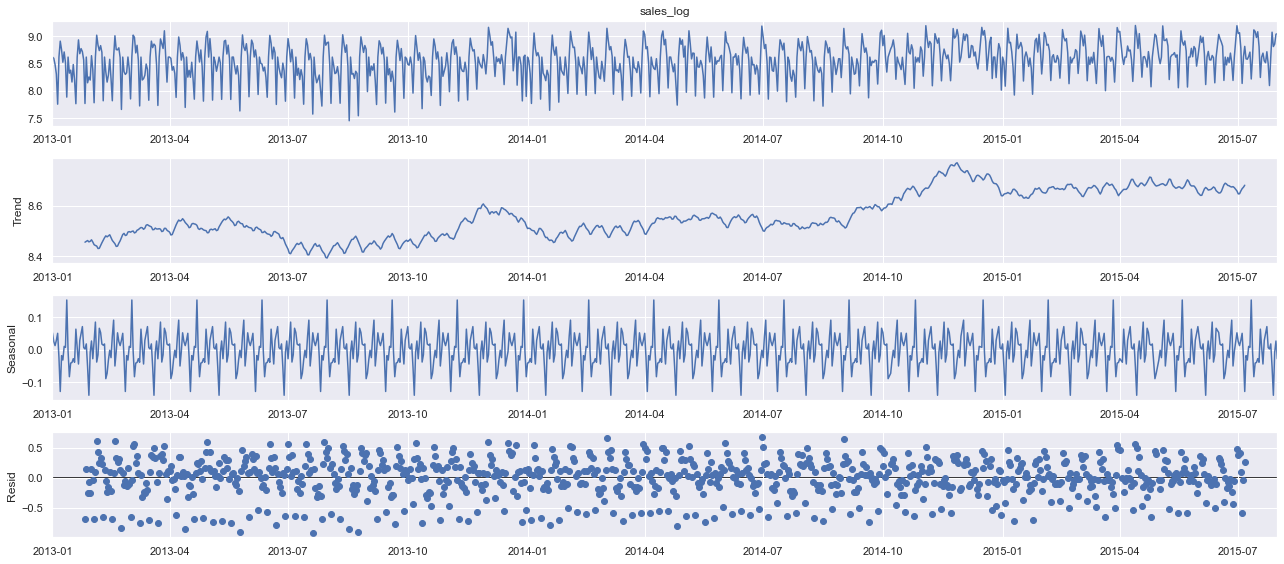

In [90]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "additive",period=50)
fig = decomposition.plot()

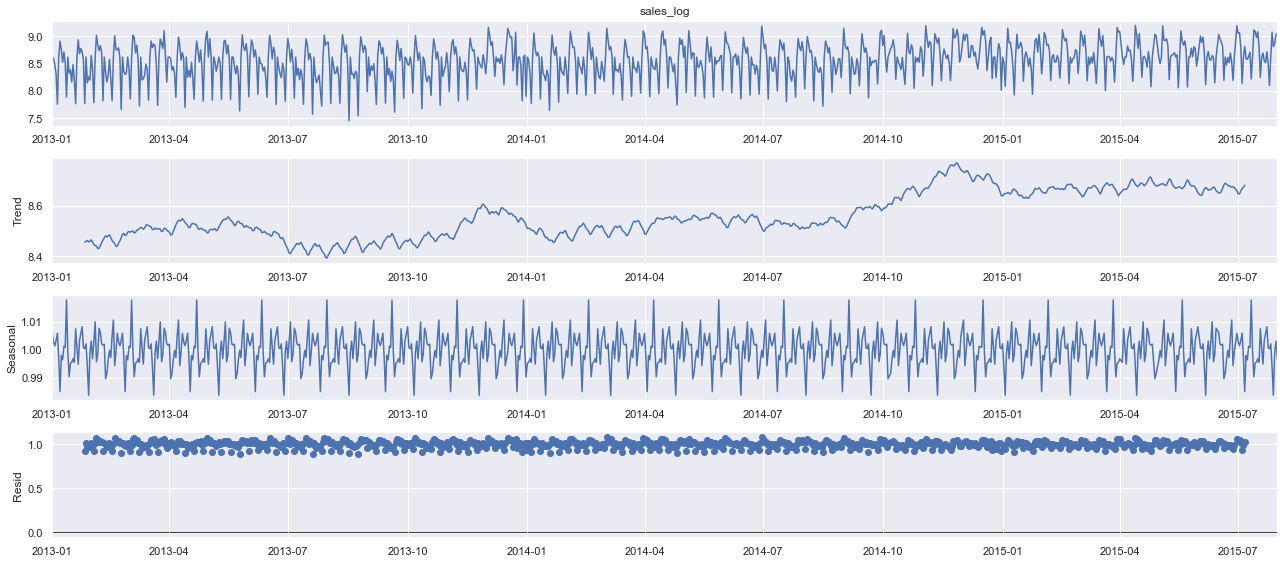

In [91]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "multiplicative",period=50)
fig = decomposition.plot()

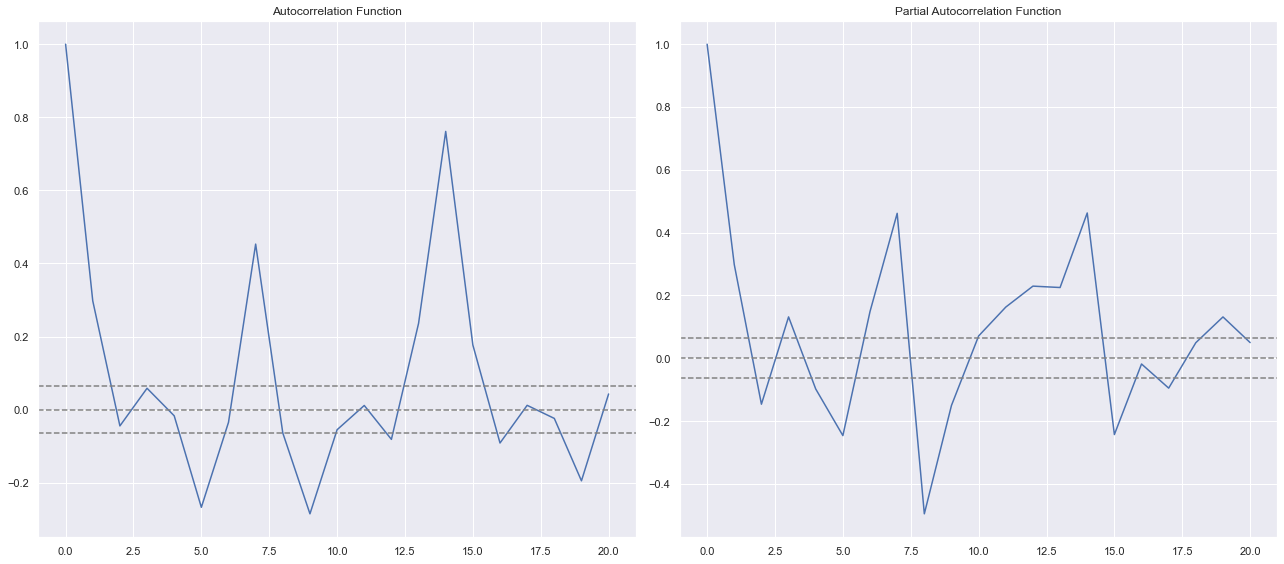

In [92]:
#ACF & PACF plots

lag_acf = acf(new_df['sales_log'], nlags=20) # MA 
lag_pacf = pacf(new_df['sales_log'], nlags=20, method='ols')  # AR 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

**Build and evaluate time series forecast**

Split time series data into training and test set

In [94]:
train_len = 750
train = new_df['sales'][0:train_len] # first 750days as training set
test = new_df['sales'][train_len:] # last 182 days as out-of-time test set

In [95]:
print(train.shape)
print(test.shape)

(750,)
(182,)


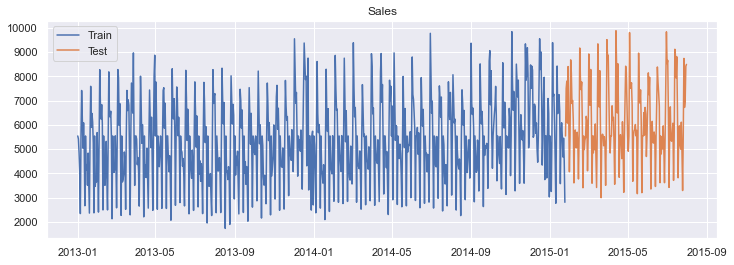

In [96]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [97]:
model = ARIMA(new_df['sales_log'], order=(2, 0, 2))
model_fit = model.fit()
print(model_fit.params)

const              8.559607
ar.L1.sales_log   -0.728296
ar.L2.sales_log   -0.030747
ma.L1.sales_log    1.101245
ma.L2.sales_log    0.234060
dtype: float64


In [98]:
new_df['ar_forecast_Log'] = model_fit.predict(new_df.index.min(), new_df.index.max())
new_df['arima_forecast'] = np.exp(new_df['ar_forecast_Log'])
new_df['arima_forecast']

date
2013-01-01    5216.632418
2013-01-02    5311.169383
2013-01-03    5238.734820
2013-01-04    5073.367276
2013-01-05    4832.552761
                 ...     
2015-07-27    5681.509875
2015-07-28    6004.357066
2015-07-29    5345.074215
2015-07-30    5782.032655
2015-07-31    5882.699352
Name: arima_forecast, Length: 932, dtype: float64

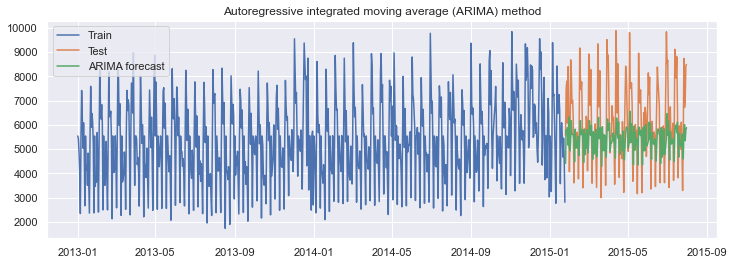

In [99]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(new_df['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

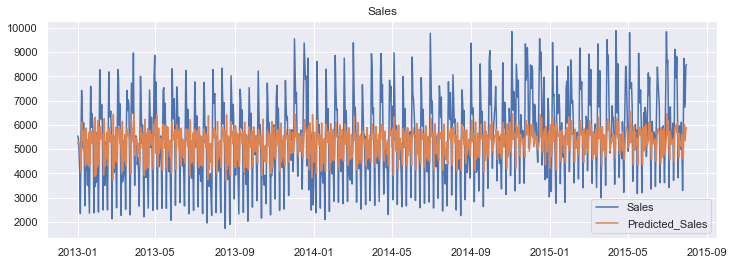

In [100]:
# plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['sales'], label='Sales')
plt.plot(new_df['arima_forecast'], label='Predicted_Sales')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [101]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, new_df['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test-new_df['arima_forecast'][test.index.min():])/test)*100,2)
Results = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
Results

,Method,RMSE,MAPE
0,ARIMA,1609.49,20.64


**VAR model**

In [103]:
#Load the dataset
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,8,2,5539.358418,0,0,0,a,1,0,8.619634,8.559607,5216.632418
2013-01-02,8,3,5419.000000,698,1,0,0,1,0,8.597667,8.577567,5311.169383
2013-01-03,8,4,4842.000000,662,1,0,0,1,0,8.485083,8.563835,5238.734820
2013-01-04,8,5,4059.000000,517,1,0,0,1,0,8.308692,8.531760,5073.367276
2013-01-05,8,6,2337.000000,312,1,0,0,0,0,7.756623,8.483130,4832.552761


**Split the dataset to training & testing**

In [104]:
#split the dataset
nobs = 182
train, test = new_df[0:-nobs], new_df[-nobs:]

# Check size
print(train.shape)
print(test.shape)  

(750, 12)
(182, 12)


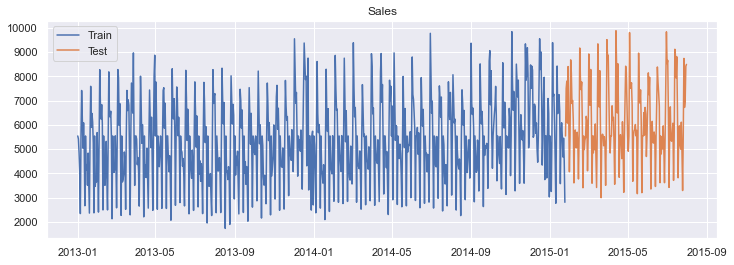

In [105]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

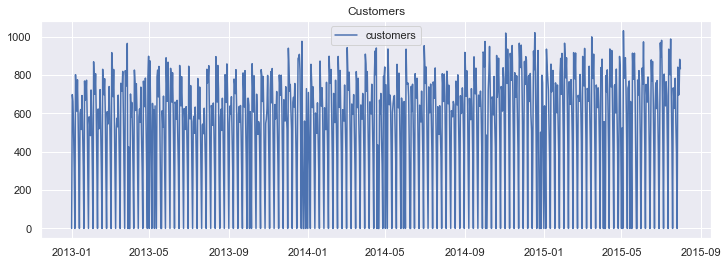

In [106]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [107]:
(new_df['customers']==0).sum()

158

In [108]:
#impute the NAN values
new_df['customers']=new_df['customers'].replace(0, np.nan)

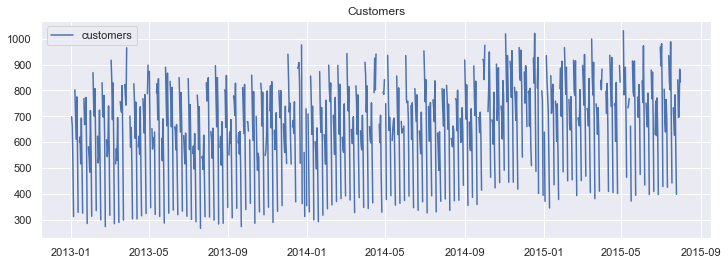

In [109]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [110]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [112]:
new_df['customers'] = imputer.fit_transform(np.array(new_df['customers']).reshape(-1, 1))
new_df['customers'].head()

date
2013-01-01    653.527132
2013-01-02    698.000000
2013-01-03    662.000000
2013-01-04    517.000000
2013-01-05    312.000000
Name: customers, dtype: float64

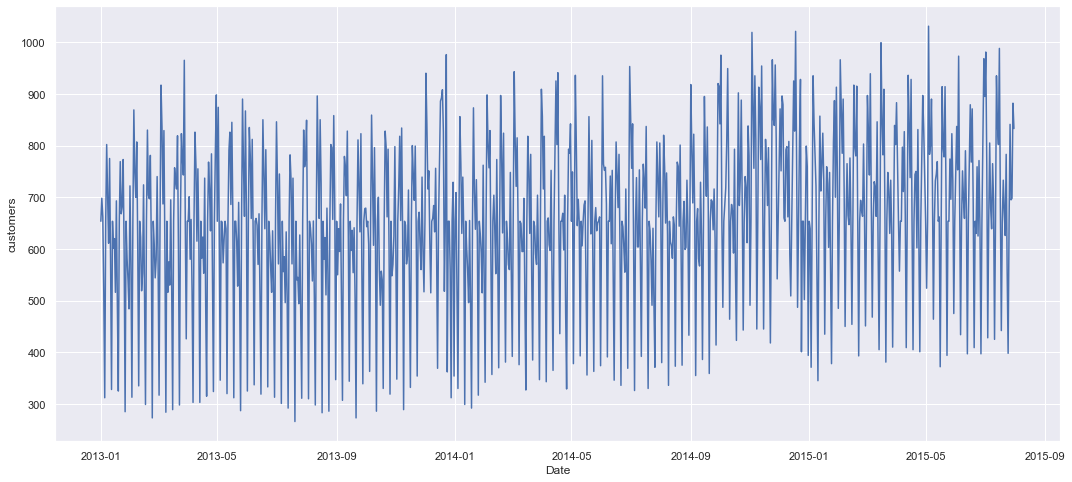

In [113]:
## plot graph
plt.xlabel('Date')
plt.ylabel('customers')
plt.plot(new_df['customers'])
plt.show()

In [114]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,8,2,5539.358418,653.527132,0,0,a,1,0,8.619634,8.559607,5216.632418
2013-01-02,8,3,5419.000000,698.000000,1,0,0,1,0,8.597667,8.577567,5311.169383
2013-01-03,8,4,4842.000000,662.000000,1,0,0,1,0,8.485083,8.563835,5238.734820
2013-01-04,8,5,4059.000000,517.000000,1,0,0,1,0,8.308692,8.531760,5073.367276
2013-01-05,8,6,2337.000000,312.000000,1,0,0,0,0,7.756623,8.483130,4832.552761


**ADF test**

In [115]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(new_df['customers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

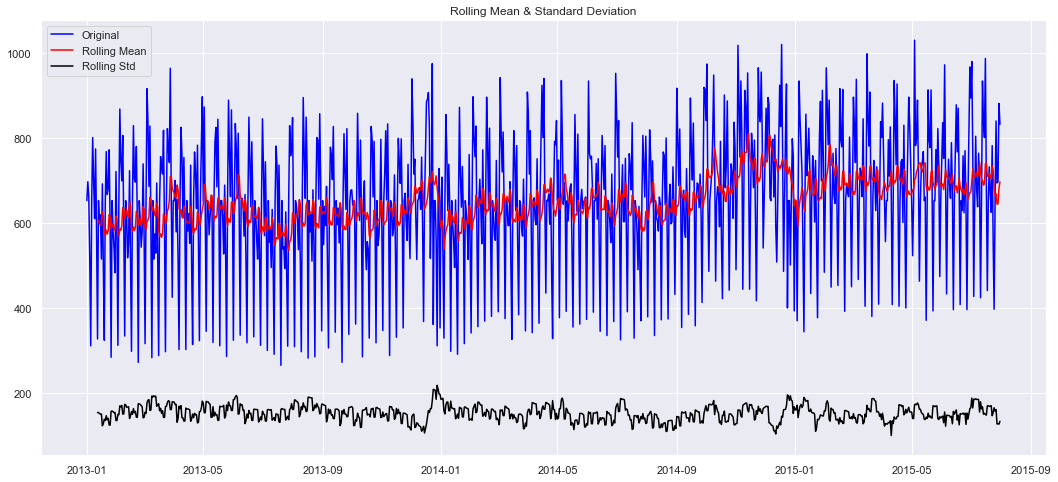

Results of Dickey Fuller Test:
Test Statistic                  -3.321760
p-value                          0.013933
#Lags Used                      18.000000
Number of Observations Used    913.000000
Critical Value (1%)             -3.437533
Critical Value (5%)             -2.864711
Critical Value (10%)            -2.568458
dtype: float64


In [125]:
test_stationarity(new_df['customers'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [123]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['customers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 2.746759
Critical Values @ 0.05: 0.46
p-value: 0.010000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is non-stationary**

In [127]:
#Log Transformation
new_df['customers_log'] = np.log(new_df['customers'])
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,8,2,5539.358418,653.527132,0,0,a,1,0,8.619634,8.559607,5216.632418,6.482384
2013-01-02,8,3,5419.000000,698.000000,1,0,0,1,0,8.597667,8.577567,5311.169383,6.548219
2013-01-03,8,4,4842.000000,662.000000,1,0,0,1,0,8.485083,8.563835,5238.734820,6.495266
2013-01-04,8,5,4059.000000,517.000000,1,0,0,1,0,8.308692,8.531760,5073.367276,6.248043
2013-01-05,8,6,2337.000000,312.000000,1,0,0,0,0,7.756623,8.483130,4832.552761,5.743003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,8,1,8739.000000,841.000000,1,1,0,1,0,9.075551,8.644972,5681.509875,6.734592
2015-07-28,8,2,6717.000000,695.000000,1,1,0,1,0,8.812397,8.700241,6004.357066,6.543912
2015-07-29,8,3,7029.000000,698.000000,1,1,0,1,0,8.857800,8.583931,5345.074215,6.548219


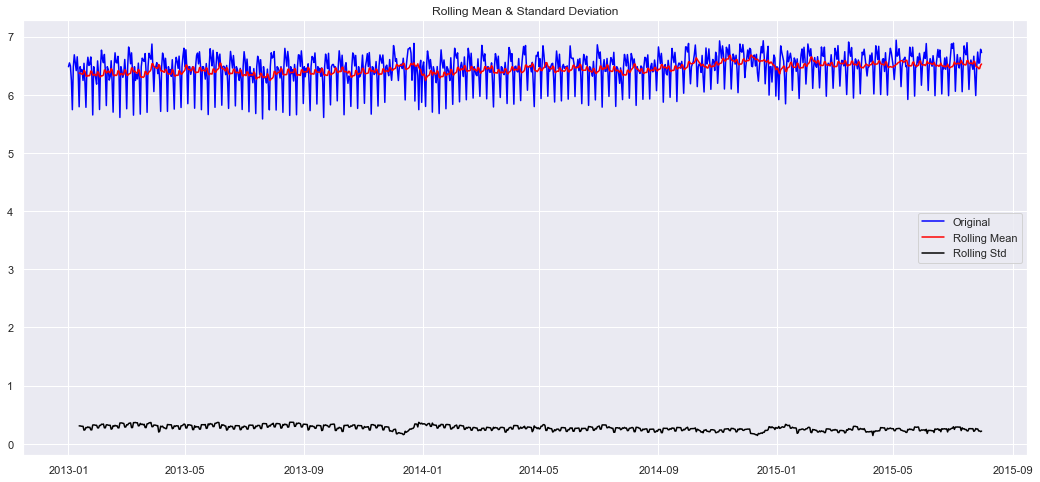

Results of Dickey Fuller Test:
Test Statistic                  -3.321760
p-value                          0.013933
#Lags Used                      18.000000
Number of Observations Used    913.000000
Critical Value (1%)             -3.437533
Critical Value (5%)             -2.864711
Critical Value (10%)            -2.568458
dtype: float64


In [128]:
test_stationarity(new_df['customers_log'])

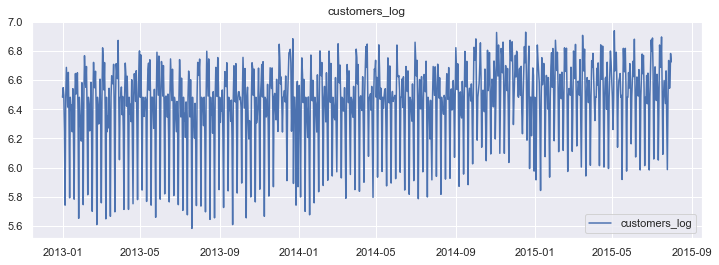

In [129]:
#plot the arima Log series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers_log'],label='customers_log')
plt.legend(loc='best')
plt.title('customers_log')
plt.show()

In [130]:
#Let's check the info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 932 entries, 2013-01-01 to 2015-07-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store            932 non-null    int64  
 1   day_of_week      932 non-null    int64  
 2   sales            932 non-null    float64
 3   customers        932 non-null    float64
 4   open             932 non-null    int64  
 5   promo            932 non-null    int64  
 6   state_holiday    932 non-null    object 
 7   school_holiday   932 non-null    int64  
 8   promo2           932 non-null    int64  
 9   sales_log        932 non-null    float64
 10  ar_forecast_Log  932 non-null    float64
 11  arima_forecast   932 non-null    float64
 12  customers_log    932 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 141.9+ KB


**Log transformation has made mean & variance constant**

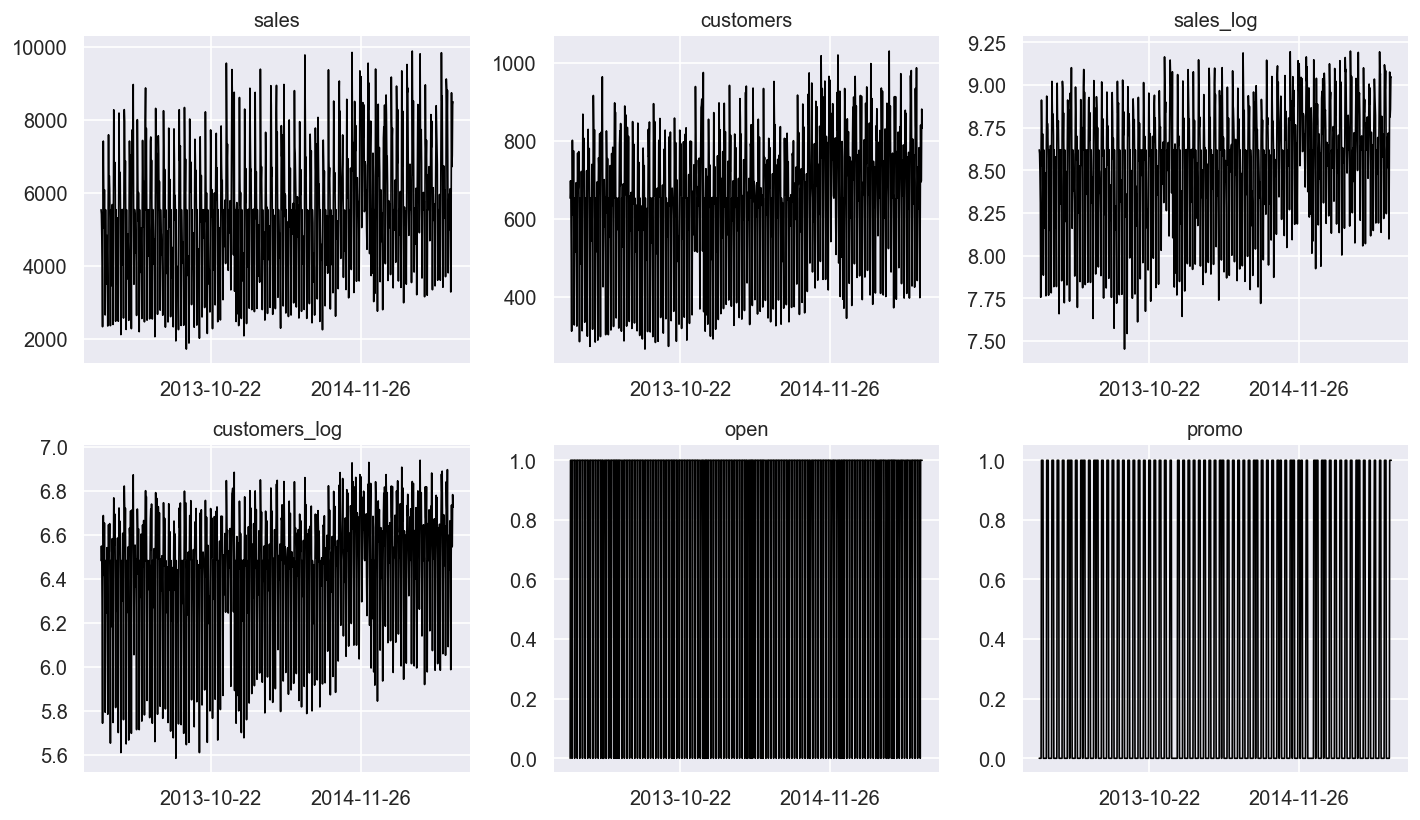

In [132]:
# Plot
ls=['sales','customers','sales_log','customers_log','open','promo','state_holiday','promo2','school_holiday']
df=new_df[ls]
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [133]:
new_df.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2', 'sales_log',
       'ar_forecast_Log', 'arima_forecast', 'customers_log'],
      dtype='object')

In [134]:
new_df1=new_df[['sales_log', 'customers_log']]
new_df1

,sales_log,customers_log
date,,
2013-01-01,8.619634,6.482384
2013-01-02,8.597667,6.548219
2013-01-03,8.485083,6.495266
2013-01-04,8.308692,6.248043
2013-01-05,7.756623,5.743003
...,...,...
2015-07-27,9.075551,6.734592
2015-07-28,8.812397,6.543912
2015-07-29,8.857800,6.548219


In [135]:
#Let's create a model
model = VAR(new_df1)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -7.670623913206736
BIC :  -7.63945575459915
FPE :  0.0004663268062851129
HQIC:  -7.658736815126191 

Lag Order = 2
AIC :  -7.9456502687325905
BIC :  -7.89365903662348
FPE :  0.00035419956472083707
HQIC:  -7.925820516564174 

Lag Order = 3
AIC :  -7.980185831449519
BIC :  -7.9073359688624425
FPE :  0.00034217602476262156
HQIC:  -7.952399039393203 

Lag Order = 4
AIC :  -8.046688676838073
BIC :  -7.952944526848686
FPE :  0.000320160712871602
HQIC:  -8.010930417620267 

Lag Order = 5
AIC :  -8.2978852842325
BIC :  -8.183211089580452
FPE :  0.00024904348050619745
HQIC:  -8.254141088942776 



In [136]:
x = model.select_order(maxlags=5)
x.summary()

,AIC,BIC,FPE,HQIC
0,-7.299,-7.289,0.0006762,-7.295
1,-7.672,-7.641,0.0004657,-7.660
2,-7.946,-7.894,0.0003539,-7.926
3,-7.982,-7.909,0.0003416,-7.954
4,-8.050,-7.956,0.0003190,-8.014
5,-8.298*,-8.183*,0.0002490*,-8.254*


In [137]:
#Let's fit the model
model_fitted = model.fit()
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Jan, 2022
Time:                     21:18:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.63946
Nobs:                     931.000    HQIC:                  -7.65874
Log likelihood:           934.612    FPE:                0.000466327
AIC:                     -7.67062    Det(Omega_mle):     0.000463336
--------------------------------------------------------------------
Results for equation sales_log
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    5.579380         0.259932           21.465           0.000
L1.sales_log             1.261260         0.104096           12.116           0.000
L1.customers_log        -1.211956         0.

In [138]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

1


In [139]:
# Input data for forecasting
forecast_input = new_df1.values[-lag_order:]
forecast_input

array([[9.04687982, 6.72503364]])

In [140]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=182)
df_forecast = pd.DataFrame(fc, index=new_df.index[-182:], columns=new_df1.columns + '_2d')
df_forecast

,sales_log_2d,customers_log_2d
date,,
2015-01-25,8.839402,6.613398
2015-01-26,8.713015,6.539612
2015-01-27,8.643034,6.498185
2015-01-28,8.604977,6.475595
2015-01-29,8.584357,6.463347
...,...,...
2015-07-27,8.560014,6.448888
2015-07-28,8.560014,6.448888
2015-07-29,8.560014,6.448888


In [141]:
df_forecast['VAR_forecast_Sales'] = np.exp(df_forecast['sales_log_2d'])
df_forecast['VAR_forecast_customers'] = np.exp(df_forecast['customers_log_2d'])
df_forecast

,sales_log_2d,customers_log_2d,VAR_forecast_Sales,VAR_forecast_customers
date,,,,
2015-01-25,8.839402,6.613398,6900.861327,745.010292
2015-01-26,8.713015,6.539612,6081.550115,692.018029
2015-01-27,8.643034,6.498185,5670.507759,663.935662
2015-01-28,8.604977,6.475595,5458.761377,649.105123
2015-01-29,8.584357,6.463347,5347.350627,641.203795
...,...,...,...,...
2015-07-27,8.560014,6.448888,5218.754717,631.998905
2015-07-28,8.560014,6.448888,5218.754717,631.998905
2015-07-29,8.560014,6.448888,5218.754717,631.998905


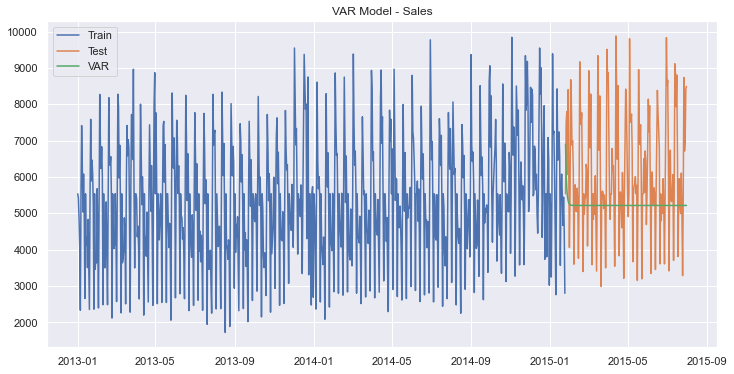

In [142]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(df_forecast['VAR_forecast_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [143]:
train_len = 750
train1 = new_df[0:train_len] # first 890days as training set
test1 = new_df[train_len:] # last 42 days as out-of-time test set

In [144]:
train1

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,8,2,5539.358418,653.527132,0,0,a,1,0,8.619634,8.559607,5216.632418,6.482384
2013-01-02,8,3,5419.000000,698.000000,1,0,0,1,0,8.597667,8.577567,5311.169383,6.548219
2013-01-03,8,4,4842.000000,662.000000,1,0,0,1,0,8.485083,8.563835,5238.734820,6.495266
2013-01-04,8,5,4059.000000,517.000000,1,0,0,1,0,8.308692,8.531760,5073.367276,6.248043
2013-01-05,8,6,2337.000000,312.000000,1,0,0,0,0,7.756623,8.483130,4832.552761,5.743003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-20,8,2,5540.000000,727.000000,1,0,0,0,0,8.619750,8.548321,5158.086989,6.588926
2015-01-21,8,3,4670.000000,603.000000,1,0,0,0,0,8.448914,8.600951,5436.824916,6.401917
2015-01-22,8,4,5447.000000,748.000000,1,0,0,0,0,8.602820,8.487665,4854.517546,6.617403


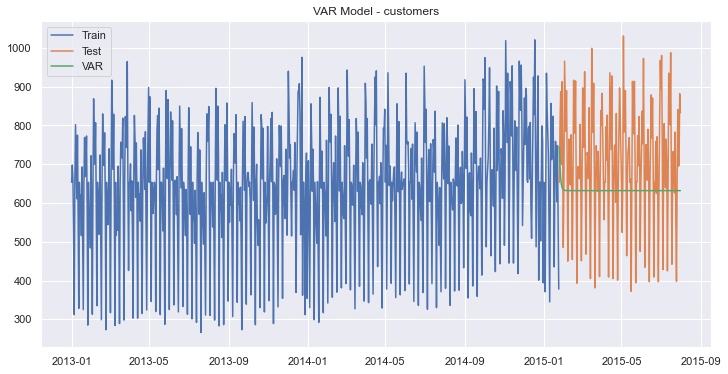

In [145]:
plt.figure(figsize=(12,6)) 
plt.plot(train1['customers'], label='Train')
plt.plot(test1['customers'], label='Test')
plt.plot(df_forecast['VAR_forecast_customers'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - customers')
plt.show()

In [146]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], df_forecast['VAR_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-df_forecast['VAR_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VAR'], 'RMSE': [rmse],'MAPE': [mape] })

In [147]:
tempResults

,Method,RMSE,MAPE
0,VAR,1818.08,21.56


In [148]:
results = pd.concat([Results , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1609.49,20.64
0,VAR,1818.08,21.56


**Johansen-Impulse**

In [149]:
joh_model1 = coint_johansen(new_df[['sales','customers']],-1,1)

In [150]:
joh_model1

In [151]:
joh_model1.lr2

array([182.6381396 ,  13.05792544])

In [152]:
joh_model1.lr1

array([195.69606504,  13.05792544])

In [153]:
new_df[['sales','customers']].shape

(932, 2)

In [154]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [155]:
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    182.638140  195.696065
1     13.057925   13.057925 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [156]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [157]:
rank=select_coint_rank(new_df[['sales','customers']],-1,1)
print(rank.rank)

2


**Rank is two**

In [159]:
from statsmodels.tsa.stattools import coint

In [160]:
coint(new_df['sales'],new_df['customers'])#null hypothesis-There is not coint

(-6.106373153627985,
 9.537625899035902e-07,
 array([-3.90824227, -3.34270081, -3.04900867]))

9.537625899035902e-07<.05

We can reject the null hypothesis

**Sales and customers are cointegration to each other**

**VARMAX MODEL**


In [161]:
#create dymmy variables
new_df=pd.get_dummies(new_df)
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,8,2,5539.358418,653.527132,0,0,1,0,8.619634,8.559607,5216.632418,6.482384,0,1,0,0
2013-01-02,8,3,5419.000000,698.000000,1,0,1,0,8.597667,8.577567,5311.169383,6.548219,1,0,0,0
2013-01-03,8,4,4842.000000,662.000000,1,0,1,0,8.485083,8.563835,5238.734820,6.495266,1,0,0,0
2013-01-04,8,5,4059.000000,517.000000,1,0,1,0,8.308692,8.531760,5073.367276,6.248043,1,0,0,0
2013-01-05,8,6,2337.000000,312.000000,1,0,0,0,7.756623,8.483130,4832.552761,5.743003,1,0,0,0


In [162]:
new_df

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,8,2,5539.358418,653.527132,0,0,1,0,8.619634,8.559607,5216.632418,6.482384,0,1,0,0
2013-01-02,8,3,5419.000000,698.000000,1,0,1,0,8.597667,8.577567,5311.169383,6.548219,1,0,0,0
2013-01-03,8,4,4842.000000,662.000000,1,0,1,0,8.485083,8.563835,5238.734820,6.495266,1,0,0,0
2013-01-04,8,5,4059.000000,517.000000,1,0,1,0,8.308692,8.531760,5073.367276,6.248043,1,0,0,0
2013-01-05,8,6,2337.000000,312.000000,1,0,0,0,7.756623,8.483130,4832.552761,5.743003,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,8,1,8739.000000,841.000000,1,1,1,0,9.075551,8.644972,5681.509875,6.734592,1,0,0,0
2015-07-28,8,2,6717.000000,695.000000,1,1,1,0,8.812397,8.700241,6004.357066,6.543912,1,0,0,0
2015-07-29,8,3,7029.000000,698.000000,1,1,1,0,8.857800,8.583931,5345.074215,6.548219,1,0,0,0


In [163]:
exog = new_df[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']]
mod = sm.tsa.VARMAX(new_df[['sales_log', 'customers_log']], order=(1,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     ['sales_log', 'customers_log']   No. Observations:                  932
Model:                                VARMAX(1,1)   Log Likelihood                1290.063
Date:                            Fri, 14 Jan 2022   AIC                          -2526.126
Time:                                    21:27:13   BIC                          -2395.518
Sample:                                         0   HQIC                         -2476.316
                                            - 932                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):             1.98, 0.00   Jarque-Bera (JB):           3.50, 7.59
Prob(Q):                        0.16, 0.96   Prob(JB):                   0.17, 0.02
Heteroskedasticity (H):         0.90, 0.98   Skew:                      -0.12, 0.08
Prob(H) (two-sided):

In [164]:
train_len = 750
train = new_df[0:train_len] # first 7500days as training set
test = new_df[train_len:] 

start_index = test.index.min()
end_index = test.index.max()

In [165]:
print(start_index)
print(end_index)

2015-01-25 00:00:00
2015-07-31 00:00:00


In [166]:
test.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2015-01-25,8,7,5539.358418,653.527132,0,0,0,0,8.619634,8.391406,4409.013724,6.482384,1,0,0,0
2015-01-26,8,1,7502.000000,807.000000,1,1,0,0,8.922925,8.663787,5789.418778,6.693324,1,0,0,0
2015-01-27,8,2,7804.000000,887.000000,1,1,0,0,8.962392,8.631952,5608.014190,6.787845,1,0,0,0
2015-01-28,8,3,6071.000000,700.000000,1,1,0,0,8.711279,8.679639,5881.922498,6.551080,1,0,0,0
2015-01-29,8,4,8403.000000,913.000000,1,1,0,0,9.036344,8.548947,5161.317150,6.816736,1,0,0,0


In [167]:
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']])

In [168]:
predictions

,sales_log,customers_log
date,,
2015-01-25,8.522407,6.396238
2015-01-26,8.739337,6.569832
2015-01-27,8.868222,6.659125
2015-01-28,8.863655,6.667303
2015-01-29,8.776903,6.606319
...,...,...
2015-07-27,8.797080,6.625210
2015-07-28,9.008044,6.758728
2015-07-29,8.907265,6.702400


In [169]:
predictions['VARMAX_forecast_Sales'] = np.exp(predictions['sales_log'])
predictions['VARMAX_forecast_customers'] = np.exp(predictions['customers_log'])
predictions

,sales_log,customers_log,VARMAX_forecast_Sales,VARMAX_forecast_customers
date,,,,
2015-01-25,8.522407,6.396238,5026.135075,599.585342
2015-01-26,8.739337,6.569832,6243.754600,713.249740
2015-01-27,8.868222,6.659125,7102.639016,779.868331
2015-01-28,8.863655,6.667303,7070.275772,786.272049
2015-01-29,8.776903,6.606319,6482.772135,739.754673
...,...,...,...,...
2015-07-27,8.797080,6.625210,6614.901893,753.862501
2015-07-28,9.008044,6.758728,8168.526267,861.545403
2015-07-29,8.907265,6.702400,7385.433384,814.358075


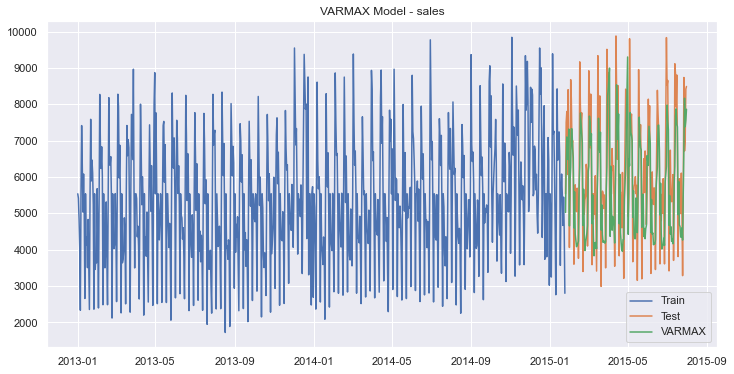

In [170]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(predictions['VARMAX_forecast_Sales'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

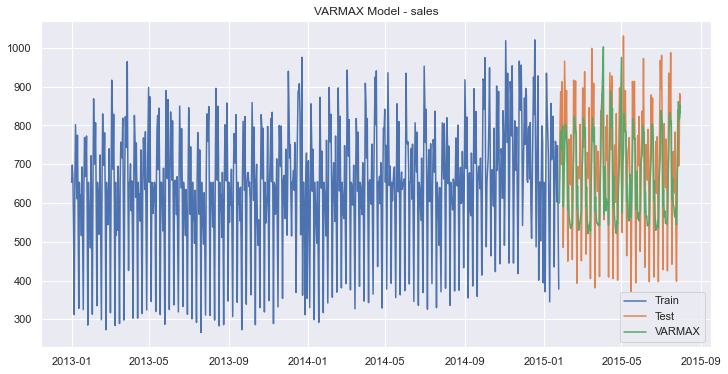

In [171]:
plt.figure(figsize=(12,6)) 
plt.plot(train['customers'], label='Train')
plt.plot(test['customers'], label='Test')
plt.plot(predictions['VARMAX_forecast_customers'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

In [172]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], predictions['VARMAX_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-predictions['VARMAX_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VARMAX'], 'RMSE': [rmse],'MAPE': [mape] })

In [173]:
results = pd.concat([results  , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1609.49,20.64
0,VAR,1818.08,21.56
0,VARMAX,1303.42,17.22


**VARMAX is the best model**

-  Is the sales data non-stationary? If so, how do you find it and correct it?

-  Is the data cointegrated? Which variables are cointegrated and how do you find them?

-  What is the impact of the number of customers on sales?

-  What is the impact of promo and promo2 variables on sales? How do you measure it?

-  **Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE**

-   Find outliers at the 99th percentile and remove them.

-   Standardize the sales and number of customers variables before modelling.

-   Determine if the data is stationary

-   If stationary then apply Vector Autoregression Model.

-   If non-stationary then specify the model in differences

-   Make sales, promo2 and any other variables you think of as dependent variables.

-   check for cointegration using the Johansen test. 

-   **Predict sales for the next 6 weeks**

# Conclusion


-   The data is stationary
-   Sales and Customers are cointegrated to each others
-   Sales will get increase as the number of customer will get increase.
-   promo has positive impact on sales
-   promo2 doesn't have any impact on sales
